In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from StrongFieldIonizer import StrongFieldIonizer, write_sfi_results, load_sfi_results

In [2]:

sim = StrongFieldIonizer()

sim.epsilon = 1
sim.t_start = 0.0
sim.t_end = sim.T
sim.N_time = 1000

sim.phi = np.pi/2

Up = sim.Up
threshold = 2.0*np.sqrt(Up)

A_ts, k_ys, k_zs, matrix = sim.calculate_matrix_elements(k_range=[-threshold, threshold], N_ks=200)


Building matrix...: 100%|██████████| 40000/40000 [00:04<00:00, 8500.12 elements/s]


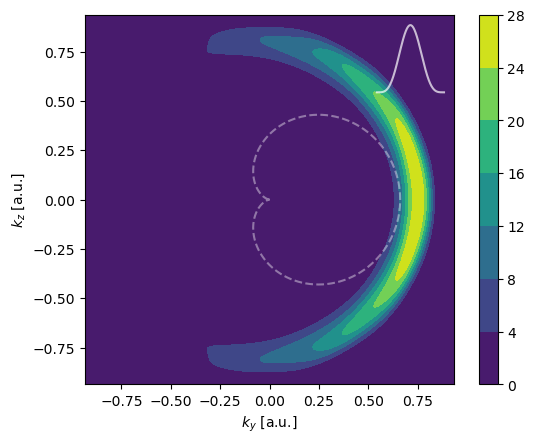

In [3]:
Z, Y = np.meshgrid(k_ys, k_zs)

fig, ax = plt.subplots()

A2 = np.sum(A_ts**2, axis=0)

A_ys = - A_ts[1] 
A_zs = - A_ts[2] 

ax.plot(A_ys, A_zs, 'w--', alpha=0.4)
ax.contourf(Y, Z, matrix)

ax.set_xlabel("$k_y$ [a.u.]")
ax.set_ylabel("$k_z$ [a.u.]")

# Store the contourf object
cf = ax.contourf(Y, Z, matrix)
fig.colorbar(cf, ax=ax)

ax.set_aspect('equal')


# Add transparent inset in the top right corner
inset_ax = inset_axes(ax, width="20%", height="20%", loc='upper right',
                      bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes)

inset_ax.plot(A2, color='white', alpha=0.7)
inset_ax.set_facecolor((0, 0, 0, 0))  # Fully transparent background
for spine in inset_ax.spines.values(): spine.set_visible(False)

# Optional: hide inset axes ticks or labels
inset_ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


In [4]:
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm

# setup simulation and k-space
sim = StrongFieldIonizer()
sim.epsilon = 1
sim.t_start = 0.0
sim.t_end   = sim.T
sim.N_time  = 1000
sim.Nc = 1

Up = sim.Up
threshold = 2.0 * np.sqrt(Up)
k_range = [ -threshold, threshold ]
N_ks    = 300

k_ys, k_zs = sim.get_k_space(k_range, N_ks)
Z, Y = np.meshgrid(k_ys, k_zs)

# sweep of phi values
phi_vals = np.linspace(0, 2*np.pi, 120)

all_A_ts = []
all_matrices = []

# run simulations
for phi in tqdm(phi_vals) : 
    sim.phi = phi
    A_ts, _, _, matrix = sim.calculate_matrix_elements(k_range=k_range, N_ks=N_ks, progress_bar=False)

    all_A_ts.append(A_ts)
    all_matrices.append(matrix)
    

100%|██████████| 120/120 [21:38<00:00, 10.82s/it]


In [5]:
write_sfi_results(outfname="./Animations/sfi_results_phi_circular.txt", simulator=sim, k_range=k_range, N_ks=N_ks, parameters=phi_vals, all_A_ts=all_A_ts, all_matrices=all_matrices)

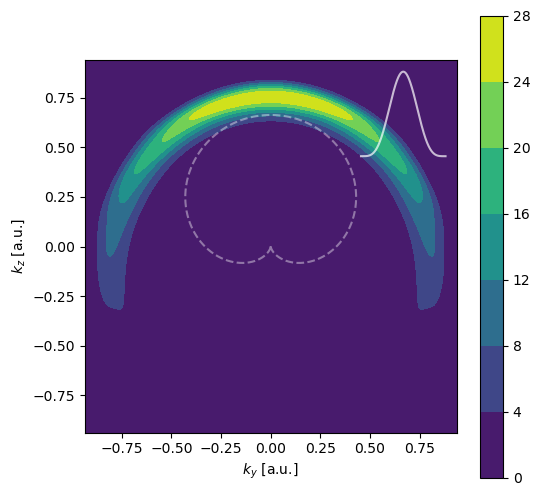

In [6]:
fig = plt.figure(figsize=(6,6))

def update(i):
    # clear the whole figure
    fig.clear()

    # retrieve simulation results
    A_ts = all_A_ts[i]
    A_ys, A_zs = -A_ts[1], -A_ts[2]
    A2 = np.sum(A_ts**2, axis=0)
    matrix = all_matrices[i]

    # do all the plotting
    ax = fig.add_subplot(1,1,1)
    cf = ax.contourf(Y, Z, matrix)
    ax.plot(A_ys, A_zs, 'w--', alpha=0.4)

    ax.set_xlabel("$k_y$ [a.u.]")
    ax.set_ylabel("$k_z$ [a.u.]")
    ax.set_aspect('equal')

    fig.colorbar(cf, ax=ax)

    # make inset plot
    iax = inset_axes(ax, width="25%", height="25%", loc='upper right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes)
    # plot envelope profile
    iax.plot(np.arange(len(A2)), A2, color='white', alpha=0.7)
    # make transparent
    iax.set_facecolor((0,0,0,0))
    # remove borders
    for spine in iax.spines.values(): spine.set_visible(False)
    # remove ticks
    iax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


ani = FuncAnimation(fig, update,
                    frames=len(phi_vals),
                    interval=100,   # ms between frames
                    blit=False)

writer = PillowWriter(fps=10)
ani.save("./Animations/sfi_phi_sweep_circular.gif", writer=writer)